In [ ]:
## Integration

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import time
from BZI.pseudopots import Al_PP
from BZI.integration import rectangular_method, rectangular_fermi_level
from BZI.symmetry import make_ptvecs, make_rptvecs
from BZI.sampling import make_cell_points
from BZI.plots import PlotMesh
# from BZI.convergence import Convergence
import matplotlib.pyplot as plt
from BZI.improved_tetrahedron_method import (calc_fermi_level, calc_total_energy, 
                                             grid_and_tetrahedra)

Find the "solution" to the Fermi level and total energy

In [3]:
grid_centering = "face"
grid_const = Al_PP.lattice.constants[0]*5
grid_consts = [grid_const]*3
grid_angles = [np.pi/2]*3
grid_vecs = make_ptvecs(grid_centering, grid_consts, grid_angles)
rgrid_vecs = make_rptvecs(grid_vecs)
offset = .5*np.sum(rgrid_vecs,1)
grid = make_cell_points(Al_PP.lattice.reciprocal_vectors, rgrid_vecs, offset)

<IPython.core.display.Javascript object>


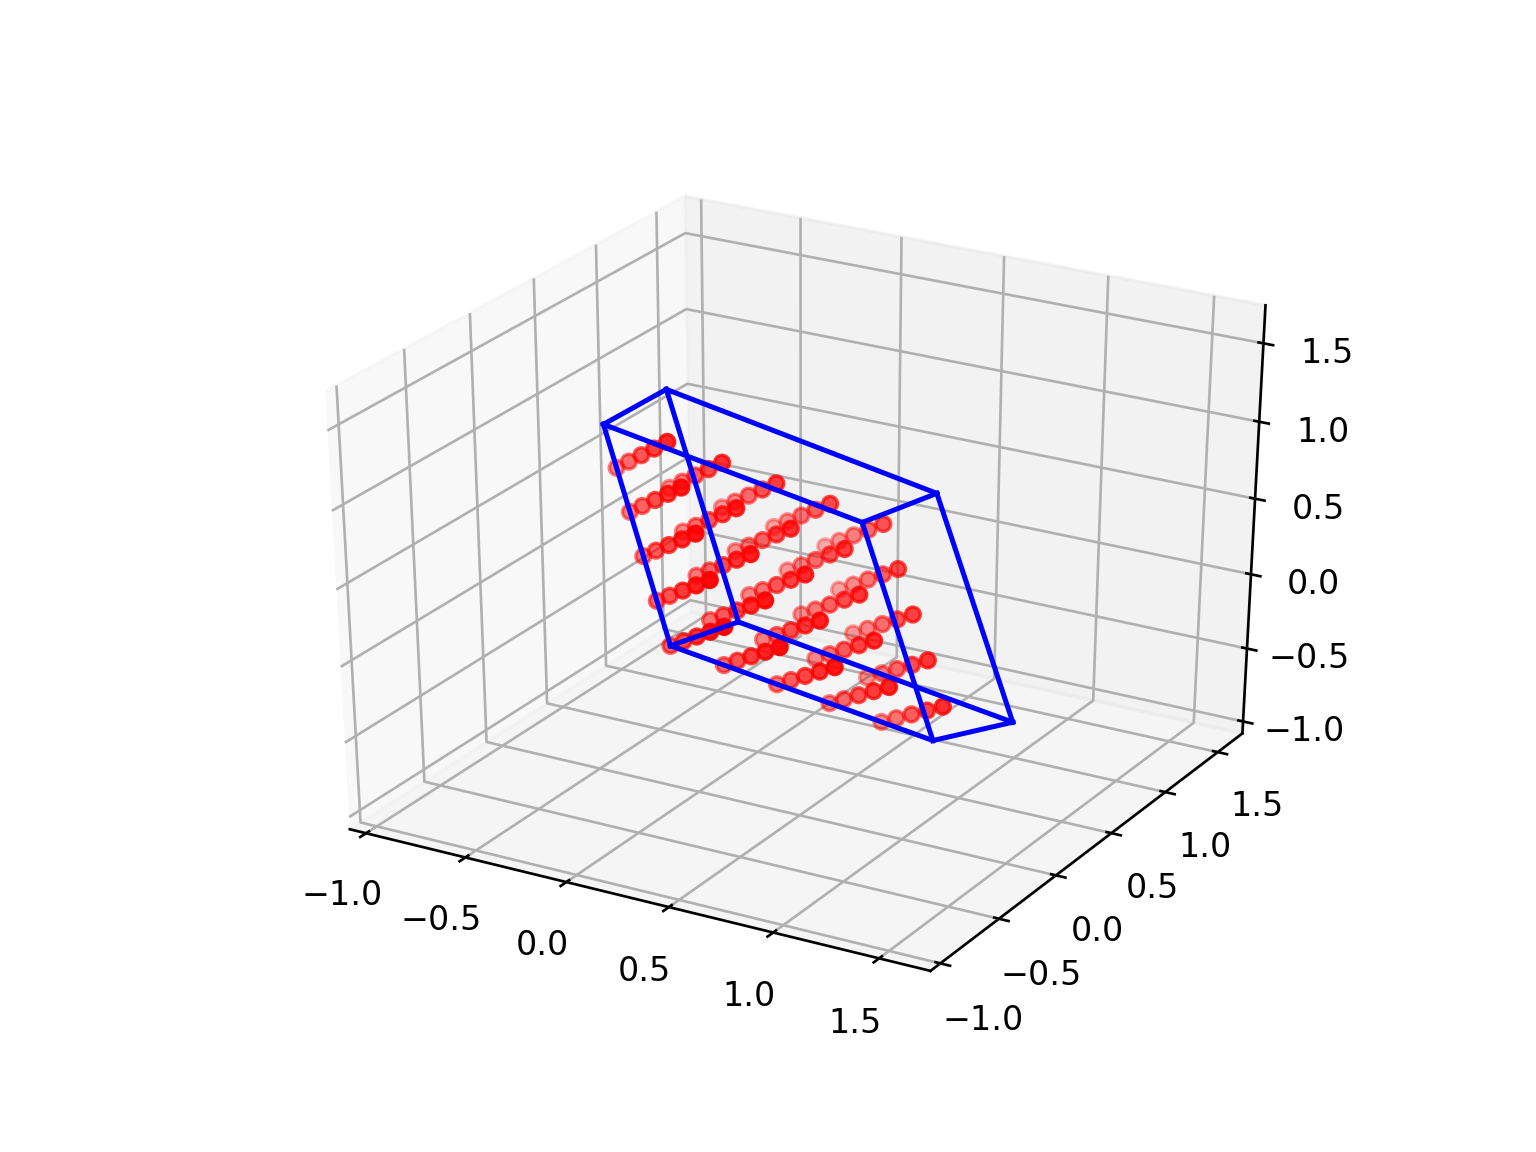

In [4]:
PlotMesh(grid, Al_PP.lattice.reciprocal_vectors, offset)

In [5]:
fermi_level = rectangular_fermi_level(Al_PP,grid)

In [6]:
Al_PP.fermi_level = fermi_level

In [7]:
Al_PP.fermi_level

11.243702435386162

In [8]:
rectangular_method(Al_PP, grid)

22.676922050835419

In [16]:
ndivs = [5]*3
offset = [0]*3
grid,tetrahedra = grid_and_tetrahedra(Al_PP, ndivs, offset)
weights = np.ones(len(tetrahedra))

In [17]:
fermlev = calc_fermi_level(Al_PP, tetrahedra, weights, grid)

In [18]:
fermlev

11.461774634890716

In [55]:
Al_PP.fermi_level = fermlev

In [56]:
toten = calc_total_energy(Al_PP, tetrahedra, weights, grid)

In [ ]:
9.75945

In [57]:
toten

9.7594544655646285

Not only is the Fermi level higher but the total energy is much less (maybe a factor of 2 is missing somewhere). I need to double check that the Fermi level is calculated correctly. It's probably just a result of not including enough empty bands.

Neither fermi level nor band energy changes when the number of band included in the calculation increased. The problem must lie elsewhere. Since both appear to be wrong (I wouldn't expect the Fermi level to be off by .7 eV), I need to investigate both. Since the rectangular method is quite simple, I expect the error to be in the improved linear tetrahedron calculations. First let's see if I can get away with only including one extra band in the calculation of the Fermi level.

I can get away with only one more band than the highest occupied band. Maybe I only need the highest occupied band.

The Fermi level changed when I included only the bands that were occupied. I should talk to Gus about this.

Maybe the total states is wrong (not likely). I should plot the Fermi level vs. kpoint density and see how the two methods vary. If they approach the same value then maybe the fermi level isn't off after all.

In [27]:
fermi_levels1 = []
fermi_levels2 = []

for i in range(2,12):
    
    grid_centering = "face"
    grid_const = Al_PP.lattice.constants[0]*i
    grid_consts = [grid_const]*3
    grid_angles = [np.pi/2]*3
    grid_vecs = make_ptvecs(grid_centering, grid_consts, grid_angles)
    rgrid_vecs = make_rptvecs(grid_vecs)
    offset = .5*np.sum(rgrid_vecs,1)
    grid = make_cell_points(Al_PP.lattice.reciprocal_vectors, rgrid_vecs, offset)
    fermi_levels1.append(rectangular_fermi_level(Al_PP,grid))

    ndivs = [i]*3
    offset = [0]*3
    grid,tetrahedra = grid_and_tetrahedra(Al_PP, ndivs, offset)
    weights = np.ones(len(tetrahedra))
    fermi_levels2.append(calc_fermi_level(Al_PP, tetrahedra, weights, grid))

<IPython.core.display.Javascript object>


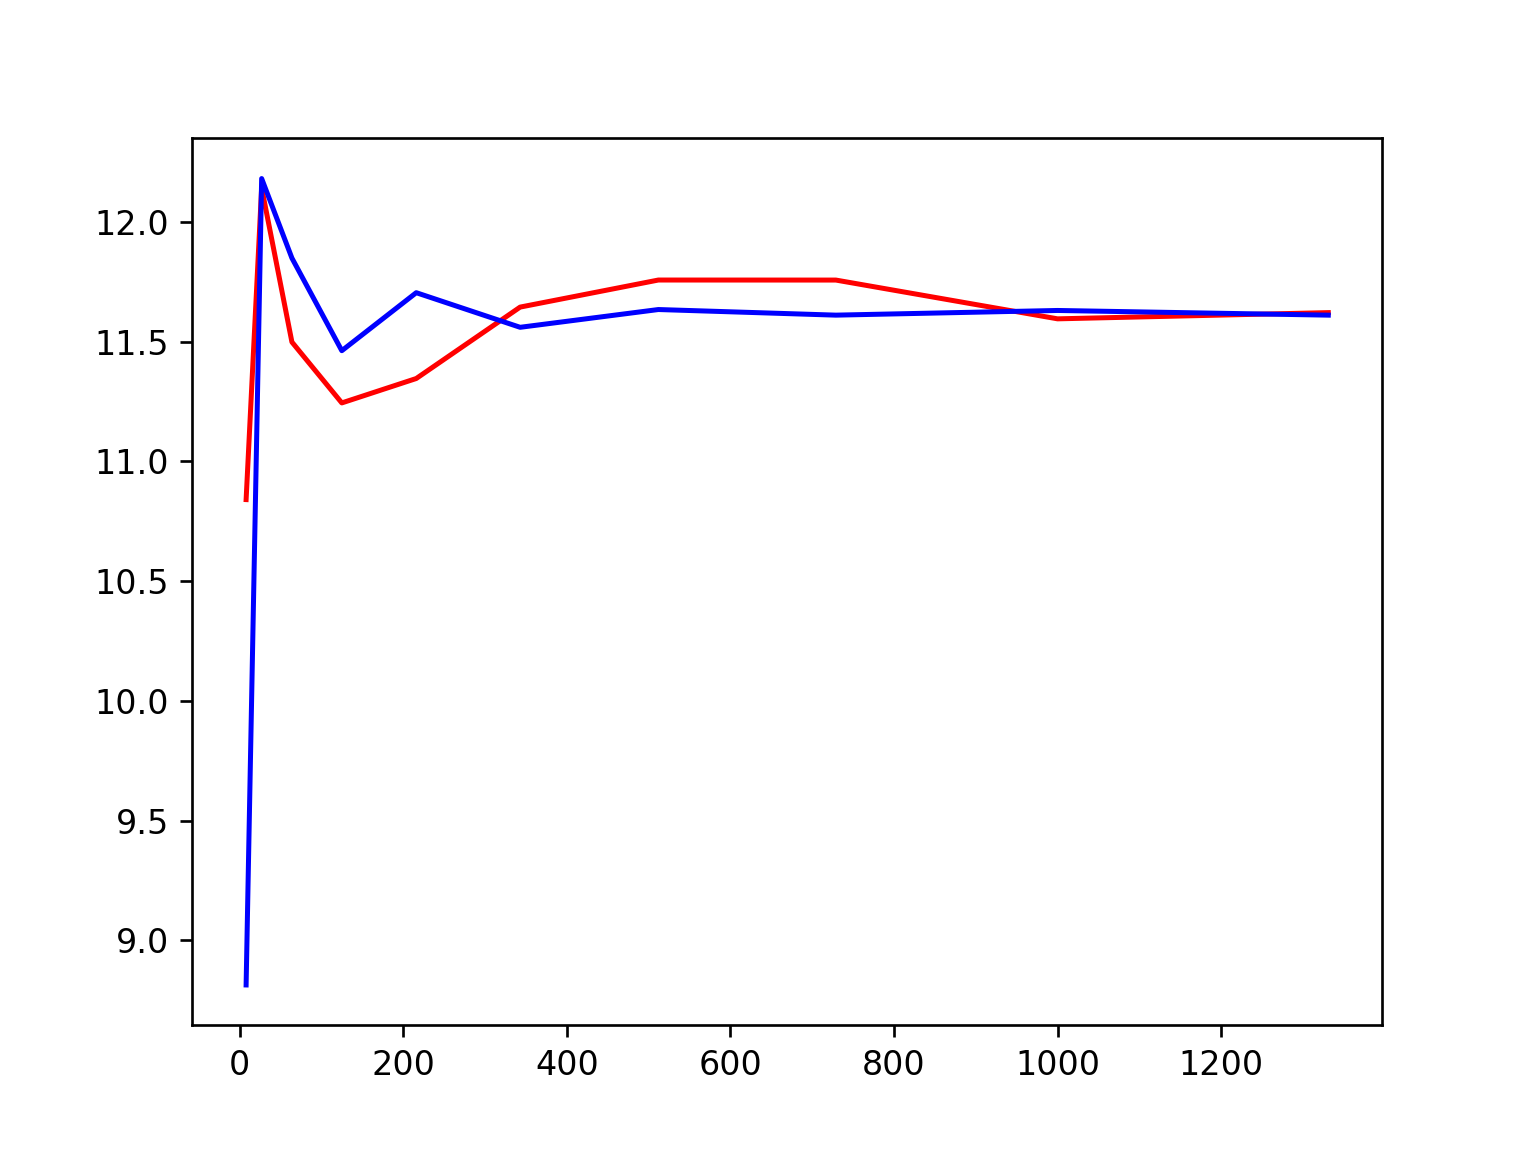

In [28]:
pts = [i**3 for i in range(2,12)]
plt.plot(pts, fermi_levels1, c="red")
plt.plot(pts, fermi_levels2,c="blue")
plt.show()

It looks like they are converging.